##まとめ
* ニューラルネットワークは、入力層、隠れ層、出力層を持つ
* 全結合層によって線形な変換が行われ、活性化関数によって非線形な変換が行われる
* 全結合層やミニバッチ処理は、行列としてまとめて計算することができる
* 誤差逆伝搬法を使って、効率的にニューラルネットワークの損失に関する勾配を求めることができる
* ニューラルネットワークで行う処理は、計算グラフによって可視化することができ、順伝搬や逆伝搬の理解に役立つ
* ニューラルネットワークの実装では、構成要素を「レイヤ」としてモジュール化することで、組み立てが容易になる
* ニューラルネットワークの高速化において、データのビット精度とGPUによる並列計算が重要である

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
ROOT_PATH='/content/drive/My Drive/Colab Notebooks/zero_DL_2'
sys.path.append(ROOT_PATH)

import numpy as np
import matplotlib.pyplot as plt

Mounted at /content/drive


##ニューラルネットワークの推論

In [ ]:
class Sigmoid:
    def __init__(self):
        self.params=[]

    def forward(self,x):
        return 1/(1+np.exp(-x))

class Affine:
    def __init__(self,W,b):
        self.params=[W,b]

    def forward(self,x):
        W,b=self.params
        out=np.dot(x,W)+b
        return out

##レイヤとしてのクラス化と順伝搬の実装

In [ ]:
class TwoLayerNet:
    def __init__(self,input_size,hidden_size,output_size):

        W1=np.random.randn(input_size,hidden_size)
        b1=np.zeros(hidden_size)
        W2=np.random.randn(hidden_size,output_size)
        b2=np.zeros(output_size)

        self.layers=[Affine(W1,b1),
                     Sigmoid(),
                     Affine(W2,b2)]

        self.params=[]

        for layer in self.layers:
            self.params+=layer.params

    def predict(self,x):
        for layer in self.layers:
            x=layer.forward(x)

        return x

In [ ]:
x=np.random.randn(10,2)
model=TwoLayerNet(2,4,3)
model.predict(x)

array([[ 0.81959616,  0.67165632, -1.51344621],
       [ 0.43647041,  1.18706526, -1.23680148],
       [ 0.20884689,  1.49203923, -0.54877294],
       [-0.405019  ,  2.12302201, -0.94119908],
       [ 0.61084461,  0.98069123, -1.30313871],
       [ 1.01137339,  0.53009382, -1.33722565],
       [ 1.14924519,  0.42647971, -1.19723224],
       [ 0.77114916,  0.83590049, -1.00603105],
       [ 0.68228205,  0.93561467, -1.03859243],
       [-0.17109839,  1.89879852, -1.30840253]])

##ニューラルネットワークの学習

In [ ]:
def softmax(x):
    if x.ndim==2:
        x=x-x.max(axis=1,keepdims=True) #オーバーフロー対策
        x=np.exp(x)/np.sum(np.exp(x),axis=1,keepdims=True)
    elif x.ndim==1:
        x=x-x.max() #オーバーフロー対策
        x=np.exp(x)/np.sum(np.exp(x))

    return x

In [ ]:
x=np.array([[1,2,3],
           [4,5,6],
           [7,8,9]])
y=np.array([1,2,3])
print(softmax(x))
print(softmax(y))

[[0.09003057 0.24472847 0.66524096]
 [0.09003057 0.24472847 0.66524096]
 [0.09003057 0.24472847 0.66524096]]
[0.09003057 0.24472847 0.66524096]


In [ ]:
def cross_entropy_error(y,t):
    if y.ndim==1:   #バッチサイズが１の場合
        y=np.reshape(1,y.size)
        t=np.reshape(1,t.size)

    if t.ndim!=1:   #tがone_hot-vectorの場合、ラベル表記に変換する
        t=np.argmax(t,axis=1)
    batch_size=y.shape[0]
    
    #y[np.arange(batch_size),t]はnumpyのファンシーインデックスを使っている
    loss=-np.sum(np.log(y[np.arange(batch_size),t]+1e-7))/batch_size

    return loss

In [ ]:
x=np.array([[1,2,3],
           [4,5,6],
           [7,8,9]])
y=softmax(x)
t=np.array([[0,0,1],
            [1,0,0],
            [0,1,0]])

print('loss=',cross_entropy_error(y,t))

t=np.array([2,0,1])
print('loss=',cross_entropy_error(y,t))

loss= 1.407605407887487
loss= 1.407605407887487


In [ ]:
#ファンシーインデックス
#https://note.nkmk.me/python-numpy-fancy-indexing/
x=np.arange(0,20,2)
print('x=',x)
print('x[[0,3,5]]=',x[[0,3,5]])

y=np.random.randint(0,10,[5,5])
print('y=\n',y)
print('y[[0,1,2]]=\n',y[[0,1,2]])
print('y[[0,1,2],[2,1,0]]=\n',y[[0,1,2],[2,1,0]])

x= [ 0  2  4  6  8 10 12 14 16 18]
x[[0,3,5]]= [ 0  6 10]
y=
 [[4 6 9 0 3]
 [7 2 9 7 2]
 [0 2 0 5 1]
 [3 3 4 2 7]
 [5 7 8 3 1]]
y[[0,1,2]]=
 [[4 6 9 0 3]
 [7 2 9 7 2]
 [0 2 0 5 1]]
y[[0,1,2],[2,1,0]]=
 [9 2 0]


In [ ]:
class SoftmaxWithLoss:
    def __init__(self):
        self.params=[]
        self.grads=[]
        self.y=None
        self.t=None

    def forward(self,x,t):
        self.y=softmax(x)
        self.t=t
        if self.t.size==self.y.size:    #tがone-hot-vectorの場合ラベル表記に変換する
            self.t=np.argmax(self.t,axis=1)
        # if self.t.ndim!=1:
            # self.t=np.argmax(self.t,axis=1)
        loss=cross_entropy_error(self.y,self.t)
        return loss

    def backward(self,dout=1):
        #backward時のself.tはforward時にラベル表記に変換されている
        batch_size=self.t.shape[0]
        dx=self.y.copy()
        dx[np.arange(batch_size),self.t]-=1 #one_hot_vectorの１を引く(dx=(y-t)/batch_size)
        dx/=batch_size
        return dx

In [ ]:
layer=SoftmaxWithLoss()
x=np.array([[1,2,3],
            [4,5,6],
            [7,8,9]])
t=np.array([[0,0,1],
           [0,1,0],
            [0,0,1]])

loss=layer.forward(x,t)
print('loss:',loss)

# x=np.array([[1,2,3,4,5,6]])
# t=np.array([[3]])
# loss=layer.forward(x,t)
# print('loss:',loss)

dout=1
dx=layer.backward(dout)
print(dx)

loss: 0.7409390613580586
[[ 0.03001019  0.08157616 -0.11158635]
 [ 0.03001019 -0.25175718  0.22174699]
 [ 0.03001019  0.08157616 -0.11158635]]


In [ ]:
class Matmul:
    def __init__(self,W):
        self.params=[W]
        self.grads=[np.zeros_like(W)]
        self.x=None

    def forward(self,x):
        W,=self.params
        out=np.dot(x,W)
        self.x=x
        return out

    def backward(self,dout):
        W,=self.params
        dx=np.dot(dout,W.T)
        dW=np.dot(self.x.T,dout)
        self.grads[0][...]=dW
        return dx

In [ ]:
x=np.random.randint(0,10,[2,3])
print('x=\n',x)
W=np.random.randint(0,10,size=[3,2])
print('W=\n',W)

layer=Matmul(W)
y=layer.forward(x)
print('x・W=\n',y)

dout=np.random.randint(0,10,size=[*y.shape])
dx=layer.backward(dout)

print('dx=\n',dx)
print(layer.grads)

x=
 [[8 6 9]
 [7 1 2]]
W=
 [[2 1]
 [6 0]
 [7 9]]
x・W=
 [[115  89]
 [ 34  25]]
dx=
 [[10 30 35]
 [ 8  0 72]]
[array([[40, 56],
       [30,  8],
       [45, 16]])]


##勾配の導出と逆伝搬の実装

In [ ]:
class Sigmoid2:
    def __init__(self):
        self.params=[]
        self.grads=[]
        self.out=None

    def forward(self,x):
        out=1/(1+np.exp(-x))
        self.out=out
        return out

    def backward(self,dout):
        dx=self.out*(1.-self.out)*dout
        return dx

class Affine2:
    def __init__(self,W,b):
        self.params=[W,b]
        self.grads=[np.zeros_like(W),np.zeros_like(b)]
        self.x=None

    def forward(self,x):
        W,b=self.params
        out=np.dot(x,W)+b
        self.x=x
        return out

    def backward(self,dout):
        W,b=self.params
        db=np.sum(dout,axis=0)
        dx=np.dot(dout,W.T)
        dW=np.dot(self.x.T,dout)
        self.grads[0][...]=dW
        self.grads[1][...]=db
        return dx

##重みの更新

In [ ]:
class SGD:
    def __init__(self,lr=0.01):
        self.lr=lr

    def update(self,params,grads):
        for i in range(len(params)):
            params[i]-=self.lr*grads[i]

##ニューラルネットワークで問題を解く

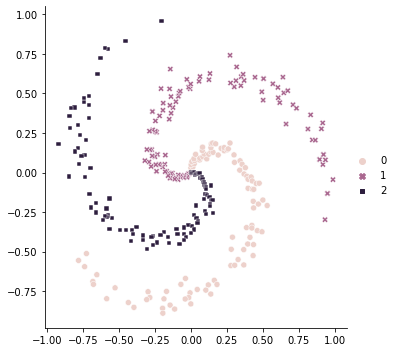

In [ ]:
from dataset import spiral
import seaborn as sns

x,t=spiral.load_data()
# print(x.shape)
# print(t.shape)
X=x[:,0]
Y=x[:,1]
C=np.argmax(t,axis=1)
sns.relplot(x=X, y=Y, hue=C,style=C)

In [ ]:
class TwoLayerNet2:
    def __init__(self,input_size,hidden_size,output_size):
        I,H,O=input_size,hidden_size,output_size

        W1=0.01*np.random.randn(I,H)
        b1=np.zeros(H)
        W2=0.01*np.random.randn(H,O)
        b2=np.zeros(O)

        self.layers=[Affine2(W1,b1),
                     Sigmoid2(),
                     Affine2(W2,b2)]

        self.loss_layer=SoftmaxWithLoss()

        self.params,self.grads=[],[]

        for layer in self.layers:
            self.params+=layer.params
            self.grads+=layer.grads

    def predict(self,x):
        for layer in self.layers:
            x=layer.forward(x)
        return x

    def forward(self,x,t):
        score=self.predict(x)
        loss=self.loss_layer.forward(score,t)
        return loss

    def backward(self,dout=1):
        dout=self.loss_layer.backward(dout)

        for layer in reversed(self.layers):
            dout=layer.backward(dout)
        return dout

In [ ]:
max_epoch=300
batch_size=30
hidden_size=10
learning_rate=1.0

x,t=spiral.load_data()

data_size=len(x)
max_iters=data_size//batch_size  #1epoch（データを全部見た）あたりの繰り返し回数

#誤差の移動平均計算用の変数
total_loss=0
loss_cnt=0

loss_list=[]    #誤差の移動平均格納用のリスト

model=TwoLayerNet2(input_size=2,hidden_size=hidden_size,output_size=3)
optimizer=SGD(lr=learning_rate)

for epoch in range(max_epoch):
    #１epochごとにデータをシャッフルする
    idx=np.random.permutation(data_size)
    x=x[idx]
    t=t[idx]

    for iters in range(max_iters):
        #バッチ作成
        x_batch=x[iters*batch_size:(iters+1)*batch_size]
        t_batch=t[iters*batch_size:(iters+1)*batch_size]

        #誤差の計算
        loss=model.forward(x_batch,t_batch)
        #勾配の計算
        model.backward()
        #重みの更新
        optimizer.update(model.params,model.grads)

        total_loss+=loss
        loss_cnt+=1

        if (iters+1)%10==0:
            #定期的に結果を出力
            avg_loss=total_loss/loss_cnt    #誤差の移動平均を求める
            print('| epoch %d | iter %d / %d | loss %.2f |'
                %(epoch+1,iters+1,max_iters,avg_loss))
            loss_list.append(avg_loss)
            total_loss,loss_cnt=0,0

| epoch 1 | iter 10 / 10 | loss 1.13 |
| epoch 2 | iter 10 / 10 | loss 1.13 |
| epoch 3 | iter 10 / 10 | loss 1.12 |
| epoch 4 | iter 10 / 10 | loss 1.12 |
| epoch 5 | iter 10 / 10 | loss 1.11 |
| epoch 6 | iter 10 / 10 | loss 1.14 |
| epoch 7 | iter 10 / 10 | loss 1.16 |
| epoch 8 | iter 10 / 10 | loss 1.11 |
| epoch 9 | iter 10 / 10 | loss 1.12 |
| epoch 10 | iter 10 / 10 | loss 1.13 |
| epoch 11 | iter 10 / 10 | loss 1.12 |
| epoch 12 | iter 10 / 10 | loss 1.11 |
| epoch 13 | iter 10 / 10 | loss 1.09 |
| epoch 14 | iter 10 / 10 | loss 1.08 |
| epoch 15 | iter 10 / 10 | loss 1.04 |
| epoch 16 | iter 10 / 10 | loss 1.03 |
| epoch 17 | iter 10 / 10 | loss 0.96 |
| epoch 18 | iter 10 / 10 | loss 0.92 |
| epoch 19 | iter 10 / 10 | loss 0.92 |
| epoch 20 | iter 10 / 10 | loss 0.87 |
| epoch 21 | iter 10 / 10 | loss 0.85 |
| epoch 22 | iter 10 / 10 | loss 0.82 |
| epoch 23 | iter 10 / 10 | loss 0.79 |
| epoch 24 | iter 10 / 10 | loss 0.78 |
| epoch 25 | iter 10 / 10 | loss 0.82 |
| epoch 2

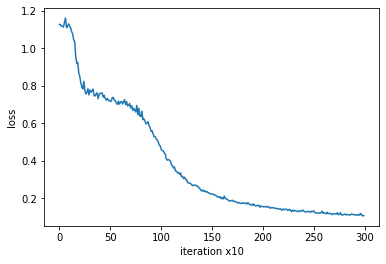

In [ ]:
plt.plot(np.arange(len(loss_list)),loss_list,label='train')
plt.xlabel('iteration x10')
plt.ylabel('loss')
plt.show()

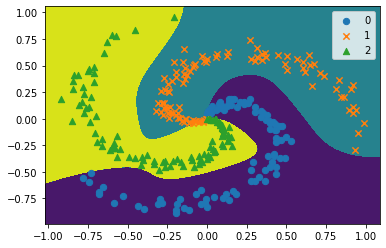

In [ ]:
# 境界領域のプロット
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]   #ravelで多次元配列を１次元ベクトルに変換→.c_で列方向に結合
# print(xx.ravel())
# print(X)
score = model.predict(X)
# print(score.shape)
predict_cls = np.argmax(score, axis=1)  #スコアが最も大きいクラス（分類）を予測とする
Z = predict_cls.reshape(xx.shape)
# print(xx.shape)
plt.contourf(xx, yy, Z) #等高線（塗りつぶし）を表示
# plt.axis('off')   #軸の表示をオフ

# データ点のプロット
x, t = spiral.load_data()
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    #データを１００個ずつ（クラスごとに）マーカーを分けて表示
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i],label=i)
plt.legend()
plt.show()

In [ ]:
predict_score=model.predict(np.array([-0.7,0.7]))
print(predict_score)
predict_label=np.argmax(predict_score)
print(predict_label)

[-4.12868148 -0.52647795  4.62932721]
2


##計算の高速化

In [ ]:
a=np.random.randn(3)
a.dtype

dtype('float64')

In [ ]:
b=np.random.randn(3).astype(np.float32)
b.dtype

dtype('float32')

In [ ]:
c=np.random.randn(3).astype('f')
c.dtype

dtype('float32')

In [ ]:
import cupy as cp

x=cp.arange(6).reshape(2,3).astype('f')
x

array([[0., 1., 2.],
       [3., 4., 5.]], dtype=float32)

In [ ]:
x.sum(axis=1)

array([ 3., 12.], dtype=float32)